## Introduction

Network systems are a combination of hardware and software used for various network transactions. Firewall systems control and monitor incoming and outgoing network traffic to detect unauthorized access. Machine learning algorithms have been applied in various real-world problems and may outperform classical network systems in preventing unauthorized internet access.

Firewall log activities require analysis to determine exactly what is allowed, dropped, and denied. It is not easy due to working with large raw data collected from the Internet Access Management in different periods of time. Firewall log files can generate a high volume of data, and the systems used can be outdated.

The main goal of this assignment is to use Machine Learning models to analyze network traffic datasets. The utilized models include Decision Tree, Random Forest, and K-Nearest Neighbor (K-NN). The model aims to predict the recommended action to be taken for each session as traffic flows through the network. After applying the models, we assessed the performance of the classifiers in terms of accuracy, precision, recall, and f1-score.

### •	Perform an initial analysis of the data (EDA). Discuss your findings and what relevance they might have on your planned classification algorithms.

Exploratory data analysis (EDA) is an important and recommended first step prior to the training of a
machine learning model. In the rest of this section, we will use some simple yet useful techniques from the
graphical EDA toolbox that may help us to visually detect the presence of outliers, the distribution of the
data, and the relationships between features.


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as pltimg
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import tree

In [2]:
#reading file
data = pd.read_csv("log2.csv")

data.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
0,57222,53,54587,53,177,94,83,2,30,1,1,allow
1,56258,3389,56258,3389,4768,1600,3168,19,17,10,9,allow
2,6881,50321,43265,50321,238,118,120,2,1199,1,1,allow
3,50553,3389,50553,3389,3327,1438,1889,15,17,8,7,allow
4,50002,443,45848,443,25358,6778,18580,31,16,13,18,allow


Let's start using .describe() and .info() to pull information about the dataset.

- .describe() - Allow the understanding of each feature (Column). It is possible to see on the numerical features the huge gap between the Q3(75%) and the max values. Also, the categorical values "NATSource Port" and "NAT Destination Port" have a huge presence of 0 values.
- .info() - Effect way to check for missing or null values.

In [3]:
data.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Bytes                 65532 non-null  int64 
 5   Bytes Sent            65532 non-null  int64 
 6   Bytes Received        65532 non-null  int64 
 7   Packets               65532 non-null  int64 
 8   Elapsed Time (sec)    65532 non-null  int64 
 9   pkts_sent             65532 non-null  int64 
 10  pkts_received         65532 non-null  int64 
 11  Action                65532 non-null  object
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [5]:
# Calculate the top unique values for each column
top_unique_values = {column: data[column].value_counts().head(3) for column in data.columns}

top_unique_values

{'Source Port': Source Port
 58638    840
 27005    513
 443      273
 Name: count, dtype: int64,
 'Destination Port': Destination Port
 53     15414
 445    12891
 443    11684
 Name: count, dtype: int64,
 'NAT Source Port': NAT Source Port
 0        28432
 48817       83
 58638       51
 Name: count, dtype: int64,
 'NAT Destination Port': NAT Destination Port
 0      28432
 53     15094
 443    11678
 Name: count, dtype: int64,
 'Bytes': Bytes
 70    10651
 66     9454
 62     5658
 Name: count, dtype: int64,
 'Bytes Sent': Bytes Sent
 70    11015
 66     9494
 62     5679
 Name: count, dtype: int64,
 'Bytes Received': Bytes Received
 0     31574
 83     1068
 90      894
 Name: count, dtype: int64,
 'Packets': Packets
 1    29829
 2    16629
 4     1852
 Name: count, dtype: int64,
 'Elapsed Time (sec)': Elapsed Time (sec)
 0     28265
 30    10322
 31     3328
 Name: count, dtype: int64,
 'pkts_sent': pkts_sent
 1    45253
 2     2909
 3     1446
 Name: count, dtype: int64,
 'pkts_r

### Understanding the target value (Action)

we were provided with a network log dataset that contains 65k observations.
- 57.43% "Allow"
- 22.86% "Deny"
- 19.61% "Drop"
- 0.08% "Reset-both"

Absolute Frequencies:
Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64

Percentages:
Action
allow         0.574376
deny          0.228697
drop          0.196103
reset-both    0.000824
Name: proportion, dtype: float64


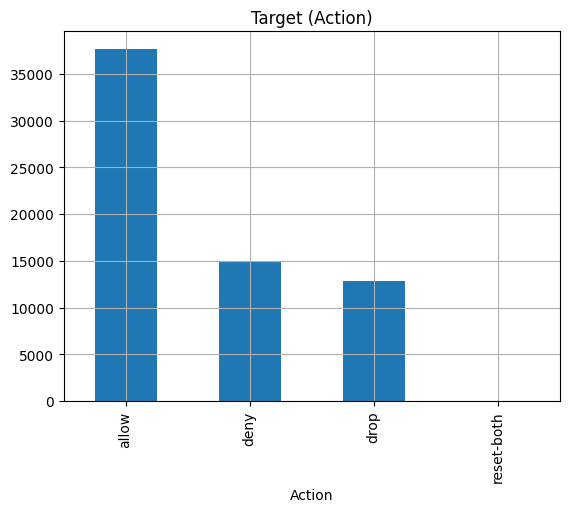

In [6]:
# target distribution
print('Absolute Frequencies:')
print(data.Action.value_counts())
print()

print('Percentages:')
print(data.Action.value_counts(normalize=True))

data.Action.value_counts().plot(kind='bar')
plt.title('Target (Action)')
plt.grid()
plt.show()

### Analyzing Numerical features.

 The values are written in scientific notation, also known as exponential notation. I used "np.log10(1+x)" to compress the large scale of the numerical values to a more manageable range.

- Upon analyzing the boxplot, it is evident that most of the features have a right-skewed distribution. This kind of skewness suggests that many observations typically involve smaller amounts of data or packets. However, it also indicates that some observations contain outliers that involve larger values (data or packets). In this context, it might be explained as large files transfers or streaming sessions on the network traffic.
- After analyzing the histograms, it confirms that the majority of the observations contain small values (data or packet), then going towards the lower end of the graph with bigger values.

In [7]:
features_num = ['Bytes', 'Bytes Sent', 'Bytes Received',
                'Packets', 'Elapsed Time (sec)',
                'pkts_sent', 'pkts_received']

In [8]:
# define log trafo for numerical features
def graph(x):
    return np.log10(1+x)

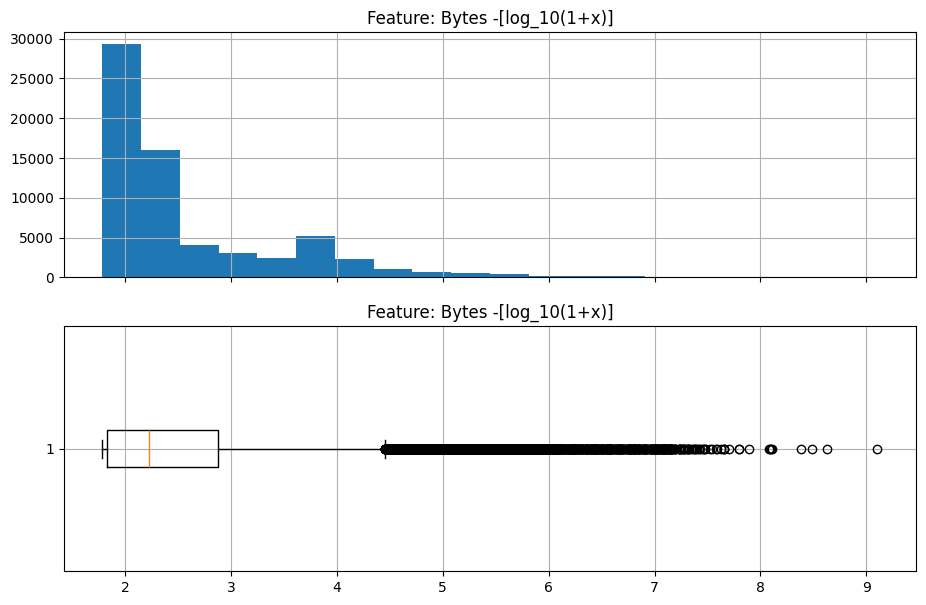

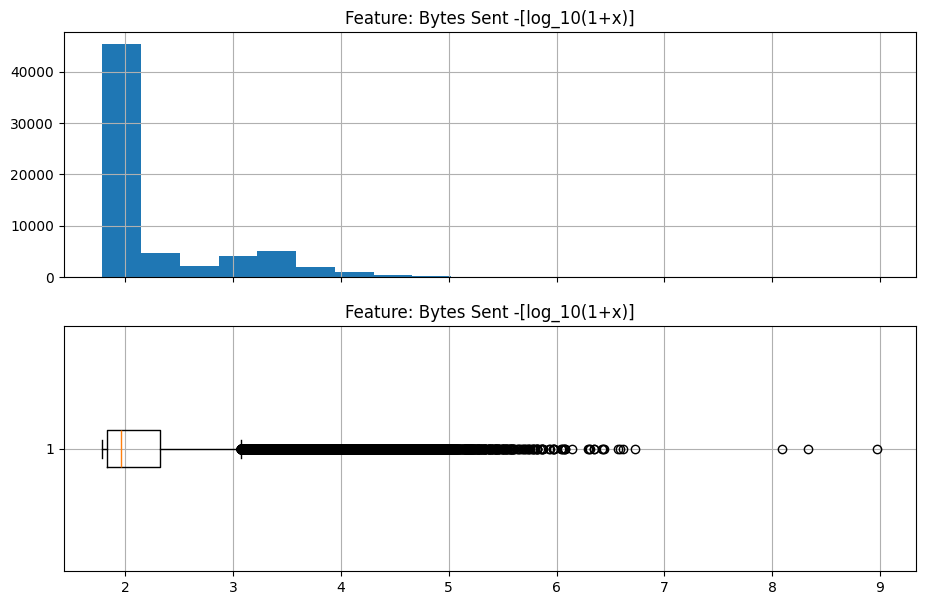

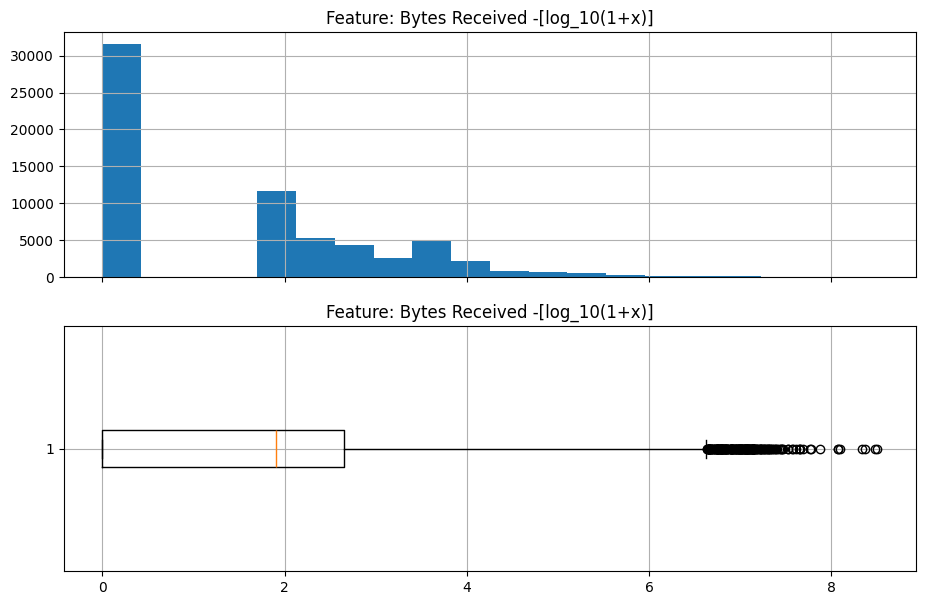

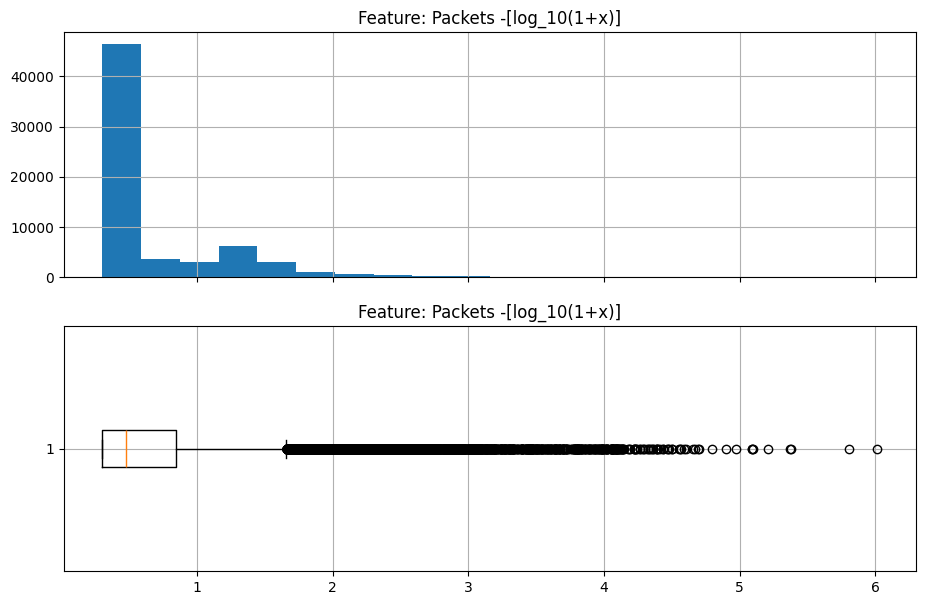

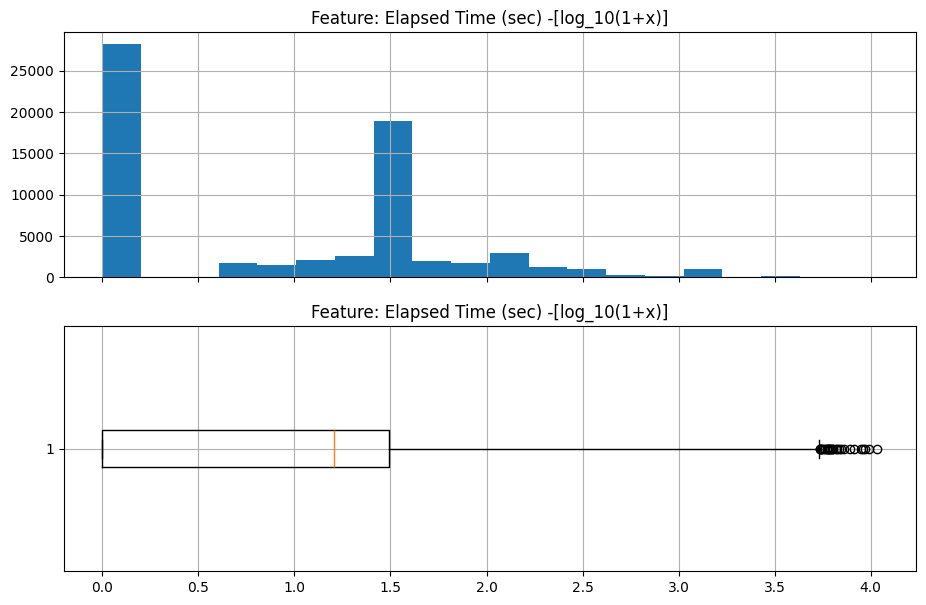

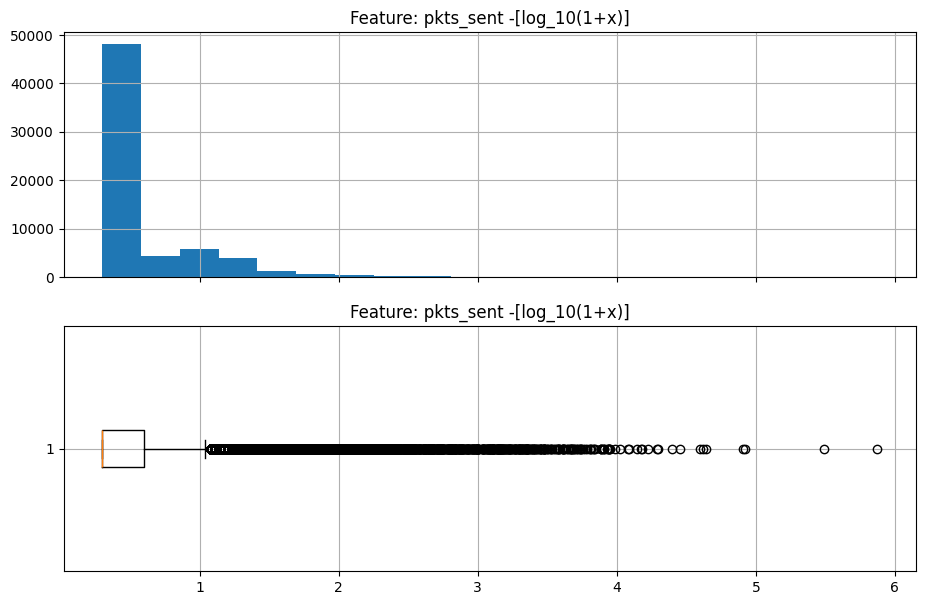

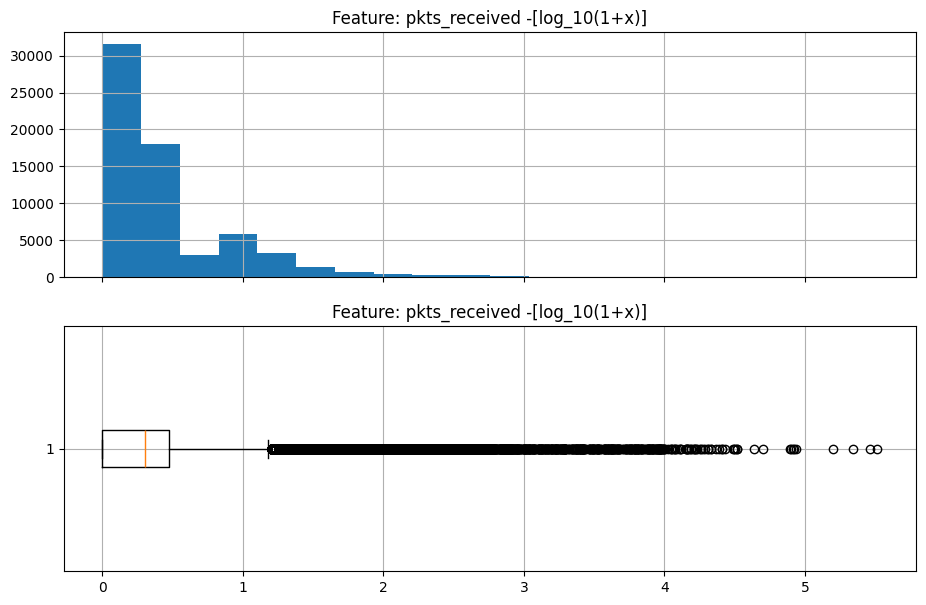

In [9]:
# plot distribution of numerical features
for f in features_num:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,7), sharex=True)
    ax1.hist(graph(data[f]), bins=20)
    ax1.grid()
    ax1.set_title('Feature: ' + f + ' -[log_10(1+x)]')
    ax2.boxplot(graph(data[f]), vert=False)
    ax2.grid()
    ax2.set_title('Feature: ' + f + ' -[log_10(1+x)]')
    plt.show()

### Analyzing Categorical Features

Even though these features are composed of numbers only, each number represents a specific port on the network (e.g. 443 = HTTPS). In this case would make no sense to use a boxplot as the range of the numbers won't mean anything. Instead, I have counted the most 10 values that appear on each feature.

#### Most used ports in the dataset:
- Source Port: Port 58638 (TCP/UCP).
- Destination Port: Port 53 (DNS), 445 (SMB) and 443(HTTPS).
- NAT Source Port: Port 0 has 28432 observations. * Might be represented by sessions that did NOT require a NAT Source Port, or missed data or packet.
- NAT Destination Port: There are an equal number of 0s, but there are significant observations for ports 53 and 443, 15094 and 11678 respectively.

In [10]:
features_cat = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']

Feature: Source Port
Source Port
58638    840
27005    513
443      273
57470    222
49418    210
6881     177
0        173
50584    116
3478     105
26900    102
Name: count, dtype: int64



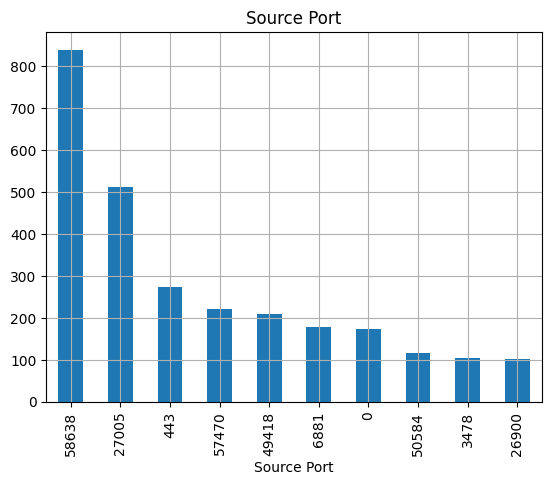

Feature: Destination Port
Destination Port
53       15414
445      12891
443      11684
80        4035
25174     1087
5900       909
37965      826
22114      767
64147      756
50584      717
Name: count, dtype: int64



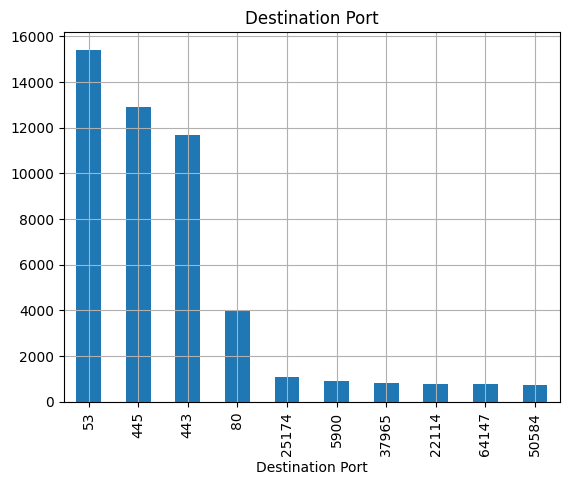

Feature: NAT Source Port
NAT Source Port
0        28432
48817       83
58638       51
50116       15
7986         5
30399        5
43757        5
57880        5
57596        5
60868        5
Name: count, dtype: int64



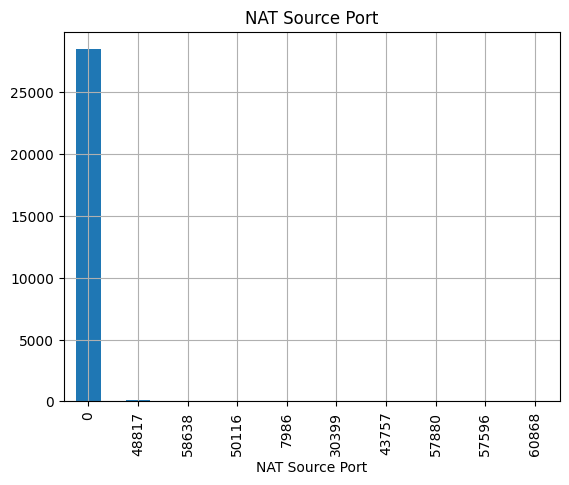

Feature: NAT Destination Port
NAT Destination Port
0        28432
53       15094
443      11678
80        4028
27015      234
27017      160
123        156
3389       156
6881       143
5228       100
Name: count, dtype: int64



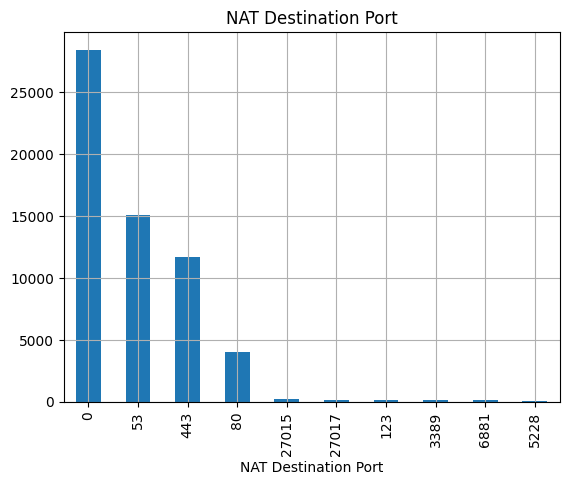

In [11]:
# show only top 10 levels for each feature
for f in features_cat:
    print('Feature:', f)
    print(data[f].value_counts()[0:10])
    print()
    data[f].value_counts()[0:10].plot(kind='bar')
    plt.title(f)
    plt.grid()
    plt.show()

Feature:Source Port - Top 10 levels only


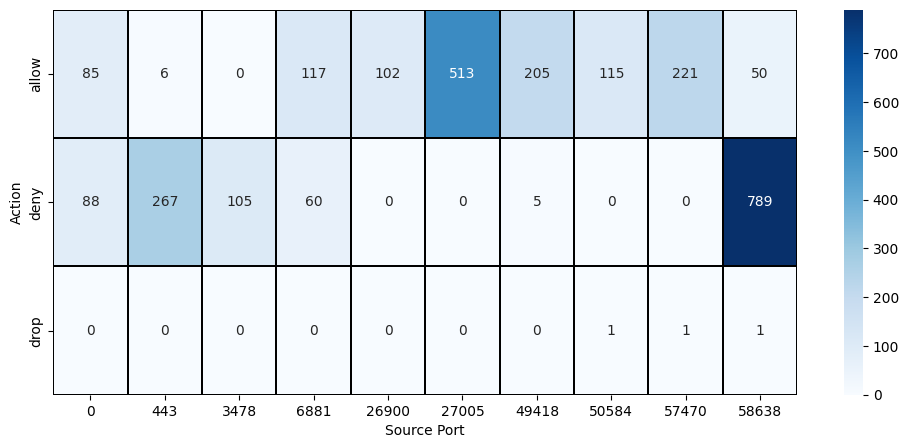

Feature:Destination Port - Top 10 levels only


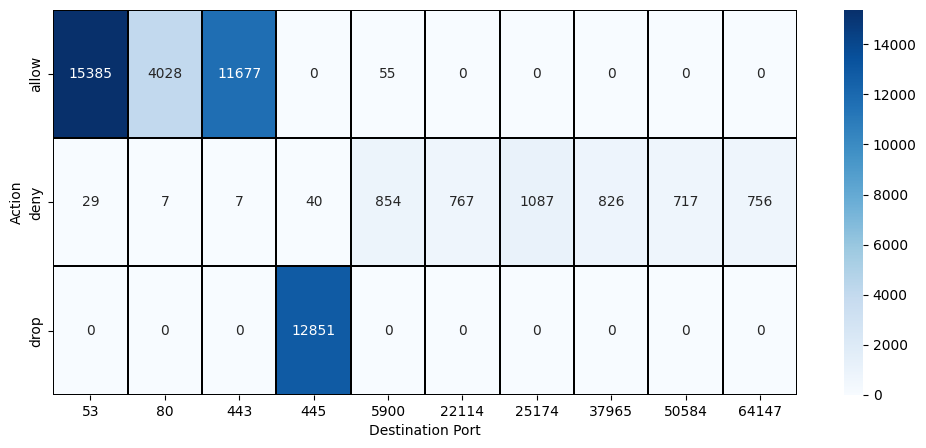

Feature:NAT Source Port - Top 10 levels only


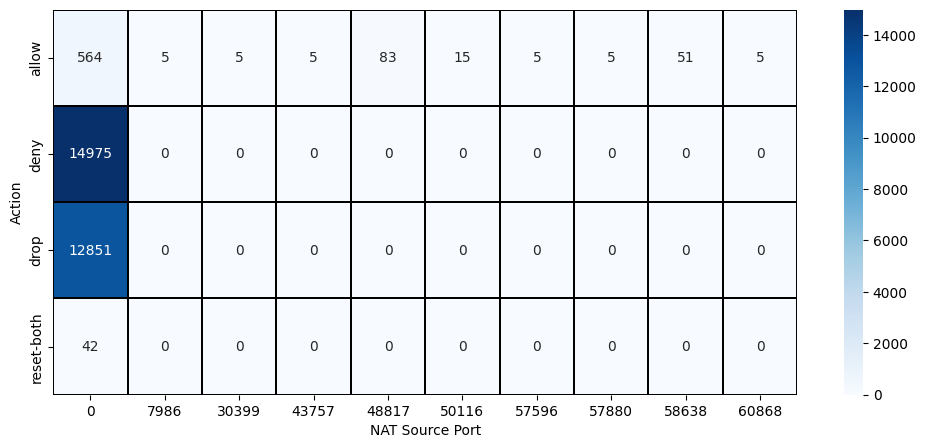

Feature:NAT Destination Port - Top 10 levels only


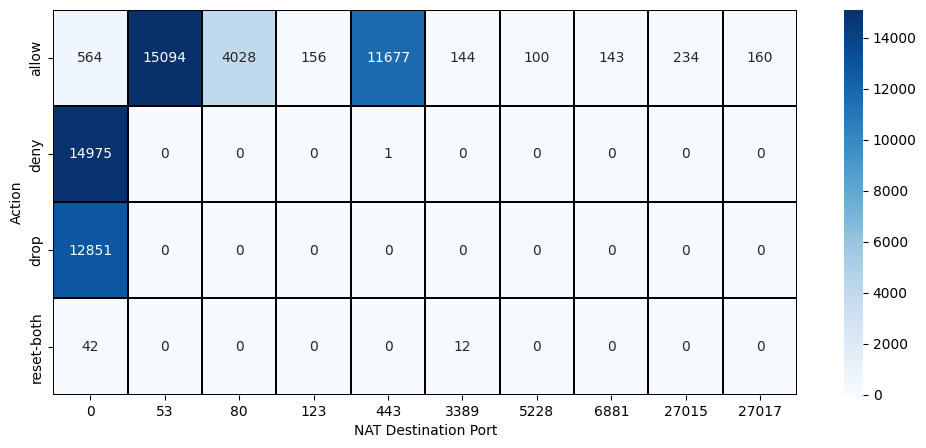

In [12]:
# visualize crosstable target vs feature (using top 10 levels only)
for f in features_cat:
    top10_levels = data[f].value_counts()[0:10].index.to_list()
    data_temp = data[data[f].isin(top10_levels)]
    ctab = pd.crosstab(data_temp.Action, data_temp[f])
    print('Feature:' + f + ' - Top 10 levels only')
    plt.figure(figsize=(12,5))
    sns.heatmap(ctab, annot=True, fmt='d',
                cmap='Blues',
                linecolor='black',
                linewidths=0.1)
    plt.show()

In the dataset, we could be able to notice that there are some "Ports" such 53, 80 and 443 that are highly correlated to "Allow", which make sense as they are related to web services (80 and 443) and DNS (53).
The massive number of observations that contain the number 0 in the NAT Source Port and Destination Port, are mostly represented in "Deny" or "Drop".

### Correlation Matrix
The correlation matrix is a square matrix that contains the Pearson product-moment correlation
coefficient (often abbreviated as Pearson's r), which measures the linear dependence between pairs of
features. The correlation coefficients are in the range –1 to 1. Two features have a perfect positive
correlation if r = 1, no correlation if r = 0, and a perfect negative correlation if r = –1. As mentioned
previously, Pearson's correlation coefficient can simply be calculated as the covariance between two
features, x and y (numerator), divided by the product of their standard deviations (denominator).(Raschka and Mirjalili, 2019)

In the following code example, we use .corr function on the eleven feature columns that we
previously visualize, and we will use the heatmap graph to plot the correlation matrix:

In [13]:
# Selecting and storing all columns except the last one in a new variable
data_corr = data.iloc[:, :-1]

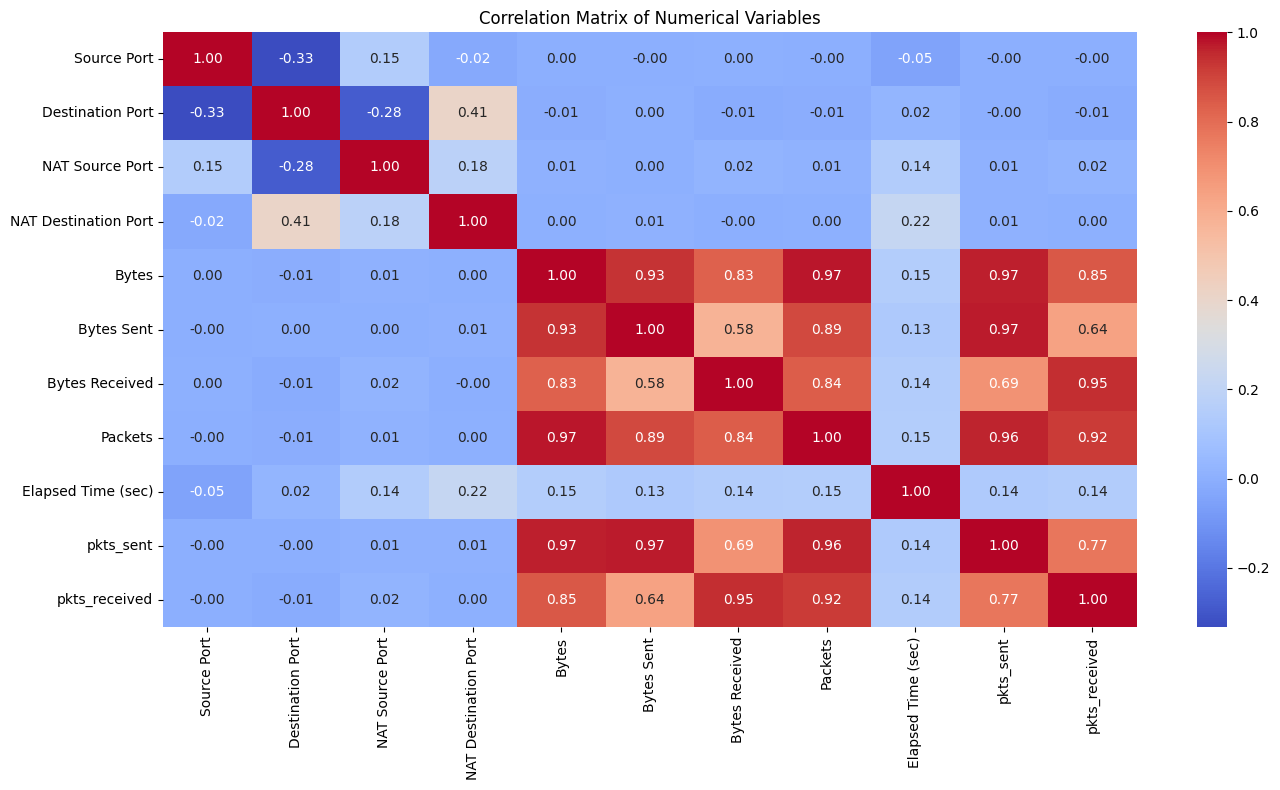

In [14]:
# Calculate the correlation matrix for the entire dataset
correlation_matrix = data_corr.corr()


# Plot the heatmap for the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10})
plt.title('Correlation Matrix of Numerical Variables')
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()

# DATA PREPARATION

Data preparation follows data understanding through EDA when data is manipulated and converted into forms that yield better results.(Provost and Fawcett, 2013)
Preparing the data includes removing or inferring missing values, and converting data to different types. This is a crucial process, and maybe the one that most confuses Data Scientists, especially the ones who do not have any experience. Usually, when taking an e-course or YouTube tutorial, the datasets come with no missing values, no bias, no skewed data, and ready-to-apply models. In the real world, the majority time of your job is preparing the data to apply the models, which are pretty simple and do not take time (as long as the data is well-cleaned). In addition, numerical values must often be scaled or normalized, it depends on the data, to be comparable across the features. Different features scales can lead models that rely on the distance between data points, such as k-nearest neighbors (KNN), to perform very poorly.




In [15]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
Action                  0
dtype: int64

I checked for duplicated observations, and noticed that there are 13281 duplicated rows. This output do not mean much in our study as repeated network traffic is a common factor.

I applied the classifiers model without these duplicated rows and the results kept the same accuracy. Altought there is a possibility of drop these rows, the drop session about is left in comments as it won't change the final results.

In [16]:
# check for duplicates values
duplicates = data[data.duplicated(keep=False)]  # Finds all duplicates, not just the first occurrence
duplicates

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action
141,51048,445,0,0,70,70,0,1,0,1,0,drop
147,55724,445,0,0,70,70,0,1,0,1,0,drop
148,51125,445,0,0,66,66,0,1,0,1,0,drop
151,51121,445,0,0,66,66,0,1,0,1,0,drop
154,51120,445,0,0,66,66,0,1,0,1,0,drop
...,...,...,...,...,...,...,...,...,...,...,...,...
65517,54874,445,0,0,70,70,0,1,0,1,0,drop
65519,49784,445,0,0,70,70,0,1,0,1,0,drop
65521,42995,26467,0,0,62,62,0,1,0,1,0,deny
65522,53314,64097,0,0,66,66,0,1,0,1,0,deny


In [17]:
# Calculate the top unique values for each column
top_unique_values = {column: duplicates[column].value_counts().head(3) for column in duplicates.columns}

top_unique_values

{'Source Port': Source Port
 58638    838
 443      185
 0        159
 Name: count, dtype: int64,
 'Destination Port': Destination Port
 445      2405
 5900      838
 25174     749
 Name: count, dtype: int64,
 'NAT Source Port': NAT Source Port
 0        13209
 58638       49
 50116       10
 Name: count, dtype: int64,
 'NAT Destination Port': NAT Destination Port
 0       13209
 5900       49
 22         10
 Name: count, dtype: int64,
 'Bytes': Bytes
 66    4657
 62    4119
 70    2300
 Name: count, dtype: int64,
 'Bytes Sent': Bytes Sent
 66    4671
 62    4133
 70    2303
 Name: count, dtype: int64,
 'Bytes Received': Bytes Received
 0       13109
 1562       47
 1626       34
 Name: count, dtype: int64,
 'Packets': Packets
 1     13046
 2       108
 46       47
 Name: count, dtype: int64,
 'Elapsed Time (sec)': Elapsed Time (sec)
 0      13114
 5         27
 194       24
 Name: count, dtype: int64,
 'pkts_sent': pkts_sent
 1     13109
 2        62
 23       47
 Name: count, dtype: 

In [18]:
# Drop the duplicate rows from the original dataset
#data.drop_duplicates(inplace=True)
#data.info()

In [19]:
label_encoder = preprocessing.LabelEncoder()

data['Action']= label_encoder.fit_transform(data['Action'])

### Data Modeling and Evaluation

We are following to next step which is the modeling stage, where data mining techniques are applied to the data. It's the scientific and technological aspects that prepare the machine learning model for application. In this study, the problem is not only applying the selected models but also evaluating each of them. In addition, the model's parameters and attributes will be tested to define which will be suitable for each model to better classify the prediction on the incoming networking traffic.

Then, we have the evaluation stage, which is to assess the data mining results and gain confidence that they are valid and reliable before moving on. It is possible to deploy results immediately after data mining but this is not the best way to proceed as your model might be not reliable
In the real world, every business has a goal when applying a machine learning model, and the evaluation stage also serves to help ensure that the model satisfies it.

# Machine Learning Models

## Classification model

Classification is the process of finding a model (or function) that describes and distinguishes data classes or concepts. The model is derived based on the analysis of a set of training data. The model is used to predict the class label of objects for which the class label is unknown (Supervised Learning). “How is the derived model presented?” The derived model may be represented in various forms, such as classification rules. (Han and Kamber, 2006) The most known rule may be the IF-THEN rule, which has numerous applications, including target marketing, fraud detection, medical diagnosis, and performance predictions.

Machine Learning Models are divided into different groups. They are: Supervised Learning, Unsupervised Learning, Semi-Supervised Learning and Active Learning and Reiforced Learning. Most of classification models are Supervised Learning, with some exceptions like Clustering, that can be used for categorization tasks without labeled data.

## Evaluation Metrics

This section presents the evaluation metrics used for the performance assessment of the classification models. This paper evaluates the classification performance of the used models using classification accuracy, precision, recall, and F1-score.


#### Confusion Matrix

Before we get into the details of different scoring metrics, let's take a look at a confusion matrix. A confusion matrix is simply a square matrix that reports the counts of the true positive (TP), true negative (TN), false positive (FP), and false negative (FN) predictions of a classifier, which is represented by a matrix *n*x*n* with the rows being labeled with the classes and the columns labeled with the predicted classes (Provost and Fawcett, 2013). In this study, we will deal with a 4x4 Matrix, as we have 4 classes in our target value. The following figure show an example of 2x2 Confusion Matrix:

![image.png](attachment:6623205b-4b00-4009-83aa-5ed0c207b552.png)

Figure 1: Confusion Matrix (Raschka and Mirjalili, 2019)


#### Accuracy


The accuracy demonstrates the proportion of the total number of correct predictions, which is one of the most popular metrics in Machine Learning, because it's very easy to measure. The classification accuracy has some problems for being too simplistic, but when calculated together with other metrics, can be very handy. The classification accuracy is calculated by dividing the total number of predictions that were correct by the total number of predictions.

![image.png](attachment:dab3c1e7-6f97-4349-b8db-4b6e55718a2f.png)

Figure 2: Accuracy (Aljabri et al., 2022)


#### Precision


Precision is very common in classification models and often used as it is needed in other metrics as such F-Measure, which we will calculate later in this study. Precision is calculated by quantifying the number of positive, “Anomalous” instances out of all the instances predicted as “Anomalous”.


![image.png](attachment:d9196428-6c96-49bf-85ae-4fb69b893823.png)

Figure 3: Precision (Aljabri et al., 2022)


#### Recall


As for recall, it also predicts the positive class predictions, however, it is calculated over the number of “Anomalous” instances in the dataset itself regardless of whether or not they were correctly predicted.


![image.png](attachment:ec2da144-040f-4471-805f-4566761e0301.png)

Figure 4: Recall (Aljabri et al., 2022)


#### F1-Score


Finally, the F1-score provides a single count that combines the values of the precision and recall in one number.


![image.png](attachment:ec421106-771c-4429-aa27-66f9f693f547.png)

Figure 5: F1-score (Aljabri et al., 2022)

## Decision Tree

Decision Tree (DT) is a widely known classification model in the data field. “Why are decision tree classifiers so popular?” The construction of DT classifiers does not require any domain knowledge or parameter setting, and therefore is appropriate for exploratory knowledge discovery. DT's representation of acquired knowledge in tree form is intuitive and easy to comprehend.(Han, Kamber and Computer, 2012)

The understanding of the model starts from the root node and branches the internal nodes into two distinctive groups. This process is repeated until a class label is reached, which is represented by a leaf.(Andriy Burkov, 2019)

In other words, the entire dataset is repeatedly split into two groups until reaching the end of the class label, in our case the "Action" feature. Now that the decision is made, the algorithm follows this process for each incoming data predicting which class label ("Action") it belongs.

In our study, DT is chosen to analyze the type of firewall access by focusing on log files. The logs activities are based on a set of rules, which are classified once the data is branched by the internal nodes, then deciding the firewall action (allow, drop, deny, and reset-both).

![image.png](attachment:5899ff41-17ba-4462-b2e4-3db053c93482.png)

Figure 6: Decision tree (ResearchGate, n.d.)

When regards to DTs, two measures play an important role in splitting the data, and they must be taken into consideration: Information Gain (IG), and the Gini Index. We won´t go through their mathematical representation and formulas, but it is important to understand how both measures work.

- Information Gain measures the expected reduction in "entropy", and is simply the difference between the impurity of the parent node and the sum of the child node impurities, the lower the impurities of the child nodes, the larger the information gain. In other words, IG is used to decide the best feature to split the data at each step. The feature with the highest information gain is chosen because it provides the most significant reduction in uncertainty.

- Gini Index measures how often a randomly chosen element is incorrectly labeled. Hence, attributes that have a lower Gini Index are preferred.

In [20]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


In [21]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [22]:
# Define the base model
dtc = DecisionTreeClassifier(random_state=42)

# Define the grid of parameters to search
param_DT = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

In [23]:
grid_search = GridSearchCV(estimator=dtc, param_grid=param_DT, cv=10, verbose=2, n_jobs=-1)

In [24]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6]},
             verbose=2)

In [25]:
#best parameters and score on the TRAINING DATA
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Score: 0.9983595612630942


In [26]:
#best score on the TEST DATA
best_modelDT = grid_search.best_estimator_
test_scoreDT = best_modelDT.score(X_test, y_test)
print("Test Score:", test_scoreDT)

Test Score: 0.9981689173723964


### GridSearchCV and RandomizedSearchCV

In this study, I decided to use two scikit-learn libraries called GridSearchCV and RandomizedSearchCV. We will see each model represented in this study contain different hyperparameters designed to tune the machine learning models. We could go and simply test one by one and compare the results. Fortunately, GridSearchCV and RandomizedSearchCV do this hard job, saving us time. We simply create a dictionary containing all the hyperparameters we would like to text, then store it on a variable that will be called on the Grid function. (Müller and Guido, 2017)

An important point to highlight is that Decision Trees do not demand too much computational power as does not have many hyperparameters and we would not need to run too many tests. On the other hand, Random Forest and K-Nearest Neighbor can demand a lot of time if applying GridSearchCV as it tries every combination of the provided hyperparameter values to find the model that performs best. The idea behind RandomizedSearchCV is to be faster, but keep the efficiency of testing hyperparameters. Although RandomizedSearchCV does not go through all the combinations, this makes it especially useful when you have limited computational resources or need to optimize over a very large space of parameters.

#### Appyling hyperparameters

Next session, the hyperparameters chosen by the GridSearchCV function will be evaluated using Confusion Matrix, Precision, Recall, and F1-Score.

In [27]:
# Training the Decision Tree Classification model on the Training set
classifierDt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf = 1, min_samples_split = 2)
classifierDt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [28]:
# Predicting the Test set results
y_pred_DT = classifierDt.predict(X_test)
print(np.concatenate((y_pred_DT.reshape(len(y_pred_DT),1), y_pred_DT.reshape(len(y_pred_DT),1)),1))

[[0 0]
 [0 0]
 [1 1]
 ...
 [0 0]
 [0 0]
 [2 2]]


In [ ]:
mat_confDT = confusion_matrix(y_test, y_pred_DT)
print(mat_confDT)
print(classification_report(y_test, y_pred_DT))
print(accuracy_score(y_test, y_pred_DT))
plt.figure( figsize = (8,5))
sns.heatmap(mat_confDT, annot=True, fmt=".1f")


[[7472    4    0    0]
 [   0 3000    9    1]
 [   0    5 2605    0]
 [   0    5    0    6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7476
           1       1.00      1.00      1.00      3010
           2       1.00      1.00      1.00      2610
           3       0.86      0.55      0.67        11

    accuracy                           1.00     13107
   macro avg       0.96      0.88      0.91     13107
weighted avg       1.00      1.00      1.00     13107

0.9981689173723964


<Axes: >

## Random Forest


In the last session, we could see that Decision Trees do not require a lot of knowledge of hyperparameters and prune techniques to achieve greater accuracy. Random Forest follows the same lead, but there are some advantages. Random Forest works very well with noise, combining many trees and averages over multiple predictions and then reducing the variance. That is the reason this model is called an ensemble model. For an ensemble model, the larger the number of trees, the better the performance of the random forest classifier at the expense of an increased computational cost. (Raschka and Mirjalili, 2019)


There are two ensemble learning paradigms: bagging and boosting.

- Bagging consists of creating many “copies” of the training data (each copy is slightly different from another) and then applying the weak learner to each copy to obtain multiple weak models and then combine them. (Andriy Burkov, 2019)
It uses bootstrap sampling, in which the subsets of the original data are created with replacement, meaning the same sample can appear more than one time in the subset. The model works independently, making the final outcome reduce its variance at first, but not increasing bias.

- Boosting does not follow the bootstrap method, it is based on the previous model's success and just adjusts the weight of the current training instance based on it. Because the models are very dependent on the previous one, the final prediction typically improves on each subset training as the mistakes are corrected by the predecessors reducing bias and sometimes variance, but with a higher risk of overfitting.


In [ ]:
# Define the base model
rfc = RandomForestClassifier(random_state=42)

# Specify parameters and distributions to sample from
param_RF = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'log2']
}

In [ ]:
# Setup the randomized search with 10 iterations and a cross-validation of 5
randomized_search = RandomizedSearchCV(rfc, param_distributions=param_RF, n_iter=100, cv=10, verbose=1, scoring ='accuracy', n_jobs=-1)


In [ ]:
randomized_search.fit(X_train, y_train)

In [ ]:
print("Best Parameters:", randomized_search.best_params_)
print("Best Score:", randomized_search.best_score_)

In [ ]:
best_modelRF = randomized_search.best_estimator_
test_scoreRF = randomized_search.score(X_test, y_test)
#test_scoreRF = best_modelRF.score(X_test, y_test)
print("Test Score:", test_scoreRF)

#### Appyling hyperparameters

Next session, the hyperparameters chosen by the GridSearchCV function will be evaluated using Confusion Matrix, Precision, Recall, and F1-Score.

In [ ]:
# Training the Random Forest Classification model on the Training set
classifierRf = RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 2, max_features = 'auto', max_depth = 20, criterion = 'entropy')
classifierRf.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred_RF  = classifierRf.predict(X_test)
print(np.concatenate((y_pred_RF .reshape(len(y_pred_RF ),1), y_pred_RF .reshape(len(y_pred_RF ),1)),1))

In [ ]:
mat_confRF = confusion_matrix(y_test, y_pred_RF )
print(mat_confRF)
print(classification_report(y_test, y_pred_RF ))
print(accuracy_score(y_test, y_pred_RF ))
plt.figure( figsize = (8,5))
sns.heatmap(mat_confRF, annot=True, fmt=".1f")

In [ ]:
test_scoreRF = accuracy_score(y_test, y_pred_RF )

In [ ]:
test_scoreRF

## K-Nearest Neighbour

The last supervised learning algorithm that we want to discuss in this study is the k-nearest neighbor (KNN) classifier, which is different in the fundamentals compared to the other machine learning classification models we have applied so far. KNN is a typical example of a lazy learner.

KNN has a specific characteristic that differs from Decision Tree and Random Forest. KNN is a non-parametric learning algorithm, which means it keeps the training dataset in memory. Random forest and Decision Tree discard the training after the model is built. Once the model faces incoming unseen data (let's call 'x'), the kNN algorithm finds k training examples closest to x and returns the majority label (in
case of classification) or the average label (in case of regression).  (Andriy Burkov, 2019)

It is called "lazy" not because of its apparent simplicity, but because it doesn't learn a discriminative function from the training data but memorizes the training dataset instead. (Raschka and Mirjalili, 2019)


In [ ]:
# Define the base model
knn = KNeighborsClassifier()

# Specify parameters and distributions to sample from
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute the nearest neighbors
    'leaf_size': [20, 30, 40, 50],  # Leaf size passed to BallTree or KDTree
    'p': [1, 2]  # Power parameter for the Minkowski metric
}

In [ ]:
# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(knn, param_distributions=param_dist_knn, n_iter=100, cv=10, verbose=2, n_jobs=-1, random_state=42)

In [ ]:
# Fit the model
random_search.fit(X_train, y_train)

In [ ]:
# Print the best parameters and the corresponding score
print("Best Parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

In [ ]:
best_modelKNN = random_search.best_estimator_
test_scoreKNN = random_search.score(X_test, y_test)
print("Test Score:", test_scoreKNN)

#### Appyling hyperparameters

Next session, the hyperparameters chosen by the GridSearchCV function will be evaluated using Confusion Matrix, Precision, Recall, and F1-Score.

In [ ]:
#Training the model

classifierKnn = KNeighborsClassifier (weights = 'distance', p = 1, n_neighbors = 5, leaf_size = 30, algorithm = 'auto')
classifierKnn.fit(X_train, y_train)

In [ ]:
# Predicting the Test set results
y_pred_KNN  = classifierKnn.predict(X_test)
print(np.concatenate((y_pred_KNN .reshape(len(y_pred_KNN ),1), y_pred_KNN .reshape(len(y_pred_KNN ),1)),1))

In [ ]:
mat_confKnn = confusion_matrix(y_test, y_pred_KNN )
print(mat_confKnn)
print(classification_report(y_test, y_pred_KNN ))
print(accuracy_score(y_test, y_pred_KNN ))
plt.figure( figsize = (8,5))
sns.heatmap(mat_confKnn, annot=True, fmt=".1f")

In [ ]:
test_scoreKNN = accuracy_score(y_test, y_pred_KNN)

In [ ]:
test_scoreKNN

# Results

For this study, we identified a very small difference among the models. Although Random Forest achieves performance better than all other classification algorithms across firewall activity detections, the other models had also great metric scores.

The firewall comprises 65,532 log activities divided into training and testing using l0-fold cross-validation methods. The results of the application on the multiclass classification problems are summarized below:

In [ ]:
# Test scores from your results
test_scores = {
    'Decision Tree': test_scoreDT,  # From your DecisionTree results
    'Random Forest': test_scoreRF,  # From your RandomForest results
    'K-NN': test_scoreKNN           # From your K-NN results
}

# Creating a bar graph
plt.figure(figsize=(10, 6))
plt.bar(test_scores.keys(), test_scores.values(), color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Test Score')
plt.title('Comparison of Model Performance')
plt.ylim(0.99, 1.0)  # Adjust as per your score range for better visualization
plt.show()

# References


1. Aljabri, M., Alahmadi, A.A., Mohammad, R.M.A., Aboulnour, M., Alomari, D.M., and Almotiri, S.H. (2022). Classification of Firewall Log Data Using Multiclass Machine Learning Models. *Electronics*, 11(12), p.1851. doi:[https://doi.org/10.3390/electronics11121851](https://doi.org/10.3390/electronics11121851).

2. AL-Behadili, H. (2021). Decision Tree for Multiclass Classification of Firewall Access. *International Journal of Intelligent Engineering and Systems*, 14(3), pp.294–302. doi:[https://doi.org/10.22266/ijies2021.0630.25](https://doi.org/10.22266/ijies2021.0630.25).

3. Andriy Burkov (2019). THE HUNDRED-PAGE MACHINE LEARNING BOOK. Andriy Burkov.

4. Grus, J. (2015). Data Science from Scratch. ‘O’Reilly Media, Inc.’

5. Han, J., Kamber, M., and Computer, P. (2012). Data mining : concepts and techniques. Amsterdam; Boston: Elsevier/Morgan Kaufmann.

6. Han, J. and Kamber, M. (2006). Data mining : concepts and techniques. Amsterdam: Elsevier.

7. Kirk, M. (2017). Thoughtful Machine Learning with Python. ‘O’Reilly Media, Inc.’

8. Müller, A.C. and Guido, S. (2017). Introduction to machine learning with Python : a guide for data scientists. Beijing: O’reilly.

9. Provost, F. and Fawcett, T. (2013). Data science for business : what you need to know about data mining and data-anal. Beijing Etc.: O’reilly.

10. Raschka, S. and Mirjalili, V. (2019). Python machine learning : machine learning and deep learning with python, scikit-learn, and tensorflow 2. Birmingham: Packt Publishing, Limited.

11. ResearchGate. (n.d.). Figure 2 (a) describes the components of a decision tree: the Nodes... [online] Available at: [https://www.researchgate.net/figure/a-describes-the-components-of-a-decision-tree-the-Nodes-represent-the-possible_fig2_303773171](https://www.researchgate.net/figure/a-describes-the-components-of-a-decision-tree-the-Nodes-represent-the-possible_fig2_303773171).

12. scikit-learn (2018). sklearn.ensemble.RandomForestClassifier — scikit-learn 0.20.3 documentation. [online] Scikit-learn.org. Available at: [https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

13. scikit-learn (2019). sklearn.model_selection.GridSearchCV — scikit-learn 0.22 documentation. [online] Scikit-learn.org. Available at: [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

14. scikit-learn (2019). sklearn.model_selection.RandomizedSearchCV — scikit-learn 0.21.3 documentation. [online] Scikit-learn.org. Available at: [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

15. scikit-learn (2019). sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.22.1 documentation. [online] Scikit-learn.org. Available at: [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

16. scikit-learn (2019). sklearn.tree.DecisionTreeClassifier — scikit-learn 0.22.1 documentation. [online] Scikit-learn.org. Available at: [https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html](https://scikit-learn.org/stable/modules/generated/sklearn.tre
This list includes books, journal